# Analyzing NYC High School Data

# Introduction

In this project, we will explore the relationship between SAT scores and demographic factors in New York City public high schools.

The SAT, also known as Scholastic Aptitute Test, is a test that high school seniors in the U.S. take every year. It is a test divided into three sections, each of which is worth `800` points. High schools use the SAT test to determine which students to admit. Usually, high average SAT scores are indicative of a good school. 

We will reach our goal by combining multiple datasets into a single, clean pandas dataframe. New York City has a significant immigrant population, so comparing demographic factors such as gender, race, and income with SAT scores is a good way to determine whether the test is fair or not. After having cleaned the dataset, we will start analysing it by creating correlations.

# Preparing the Data

## Reading in the Data

First of all, let's read in the data. We'll read each file into a pandas dataframe and then store them into a dictionary. This gives us a quick way to store them and to refer to them later on.

In [1]:
import pandas as pd
import numpy as np
import re

data_files = ["ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("~/Desktop/my_projects/data/{0}".format(f)) # Retrieving files with their path
    data[f.replace(".csv", "")] = d # Using base of filenames as key 

## Exploring the SAT Data

The dataset we are more interested in is the SAT dataset. This contains the SAT scores for each high school in New York City. We will then correlate SAT information with information from other datasets.

Let's explore the `sat_results` to check what we can learn.

In [2]:
print(data["sat_results"].head())

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

Based on this output, we can make a couple of observations: 
    
- The `DBN` is a unique ID for each school.
- We can see from the first few rows of names that we only have data about high schools.
- We only have a single row for each high school, so each `DBN` is unique in the SAT data.
- We will want to combine the three columns with SAT scores -- `SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score` -- into a single column to make the data easier to analyse.

Now, let's explore the data in a different dataset to see how we can combine them.

## Exploring the Remaining Data

In [3]:
for k in data: # Looping through each key in `data`
    print(data[k].head())

      DBN                             SchoolName  AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.             39.0   
1  01M450                 EAST SIDE COMMUNITY HS             19.0   
2  01M515                    LOWER EASTSIDE PREP             24.0   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH            255.0   
4  02M296  High School of Hospitality Management              NaN   

   Total Exams Taken  Number of Exams with scores 3 4 or 5  
0               49.0                                  10.0  
1               21.0                                   NaN  
2               26.0                                  24.0  
3              377.0                                 191.0  
4                NaN                                   NaN  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K     

Based on the first few rows of each dataset, we can make some observations:
- Each dataset has either a `DBN` column or the information we need to create one. This means that we can use the `DBN` column to combine the datasets. We will pinpoint matching rows from different datasets. We will do this by looking for identical `DBN`s. Then, we will group all f their columns together in a single dataset.
- `Location 1` looks like an interesting field for mapping. This field contains coordinates inside a larger string.
- Some datasets have many rows for each school (since the rows have duplicate `DBN` values). So we will have to do some preprocessing to make sure that each `DBN` is unique within each dataset. If we don't, we will run into problems when we combine the datasets. This will happen because we could be merging two rows in one data set with one row in another dataset.

## Reading in the Survey Data

Before proceeding with the merging steps, we need to ensure that we have all the data we want to unify. Let's now read in those files which have a more complicated format. The encoding of these files is `Windows-1252`. If we don't specify this rare encoding when reading such file, there'll be an error.

In [4]:
all_survey = pd.read_csv("~/Desktop/my_projects/data/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("~/Desktop/my_projects/data/survey_d75.txt", delimiter="\t", encoding='windows-1252')

# Combining the two files into a single dataframe
survey = pd.concat([all_survey, d75_survey], axis=0) 
survey = survey.copy()
print(survey.head())

      dbn    bn                      schoolname  d75 studentssurveyed  \
0  01M015  M015       P.S. 015 Roberto Clemente    0               No   
1  01M019  M019             P.S. 019 Asher Levy    0               No   
2  01M020  M020            P.S. 020 Anna Silver    0               No   
3  01M034  M034  P.S. 034 Franklin D. Roosevelt    0              Yes   
4  01M063  M063       P.S. 063 William McKinley    0               No   

   highschool                  schooltype  rr_s  rr_t  rr_p  ...  s_q14_2  \
0         0.0           Elementary School   NaN    88    60  ...      NaN   
1         0.0           Elementary School   NaN   100    60  ...      NaN   
2         0.0           Elementary School   NaN    88    73  ...      NaN   
3         0.0  Elementary / Middle School  89.0    73    50  ...      NaN   
4         0.0           Elementary School   NaN   100    60  ...      NaN   

   s_q14_3  s_q14_4  s_q14_5  s_q14_6  s_q14_7  s_q14_8  s_q14_9  s_q14_10  \
0      NaN      NaN 

Here's what we can immediately see from the data:
    
- There are over `2000` columns, all which we won't need. We will have to filter the data to remove the unnecessary ones. This will make it easier to print the dataframe and find correlations within it.
- The survey data has a `dbn` column that we need to convert to uppercase (`DBN`). This will make the column name consistent with the other datasets.

## Cleaning Up the Surveys

We will use the [data dictionary](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) to assess which columns to remove and which ones to keep.

According to the dictionary, the columns that we will keep are the following:

`["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]`

These columns tell us how people feel about school safety and academic performance. They also give us the `DBN`, which identifies the school. 

Before filtering columns out, let's copy the data in the `dbn` column in a new one called `DBN` for consistency.

In [5]:
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
# Filtering survey so it only contains the columns listed above
survey = survey.loc[:,survey_fields]

# Assigning survey to the key survey in the dictionary data
data["survey"] = survey

print(survey.head())

      DBN  rr_s  rr_t  rr_p    N_s   N_t    N_p  saf_p_11  com_p_11  eng_p_11  \
0  01M015   NaN    88    60    NaN  22.0   90.0       8.5       7.6       7.5   
1  01M019   NaN   100    60    NaN  34.0  161.0       8.4       7.6       7.6   
2  01M020   NaN    88    73    NaN  42.0  367.0       8.9       8.3       8.3   
3  01M034  89.0    73    50  145.0  29.0  151.0       8.8       8.2       8.0   
4  01M063   NaN   100    60    NaN  23.0   90.0       8.7       7.9       8.1   

   ...  eng_t_11  aca_t_11  saf_s_11  com_s_11  eng_s_11  aca_s_11  \
0  ...       7.6       7.9       NaN       NaN       NaN       NaN   
1  ...       8.9       9.1       NaN       NaN       NaN       NaN   
2  ...       6.8       7.5       NaN       NaN       NaN       NaN   
3  ...       6.8       7.8       6.2       5.9       6.5       7.4   
4  ...       7.8       8.1       NaN       NaN       NaN       NaN   

   saf_tot_11  com_tot_11  eng_tot_11  aca_tot_11  
0         8.0         7.7         7.5   

## Inserting DBN Fields 

When we explored all of the datasets, we noticed that `class_size` does not have a `DBN` column.

In [6]:
print(data['class_size'].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


Here below are the first few columns of `sat_results`, which have a `DBN` column.

In [7]:
print(data['sat_results'].head())

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

From looking at these cells, we can say that the `DBN` in the `sat_results` data is just a combination of `CSD` and `SCHOOL CODE` in the `class_size` data. The only difference is that the `DBN` is padded, so that `CSD` always consists of two digits. This means that we will need to add a leading `0` to the `CSD` that have only one digit. We also found out that `hs_directory` has a `dbn` column, however we need to rename it to `DBN` for consistency.

In [8]:
# Copying the dbn column into a new one called DBN
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

In [9]:
# Creating a new column called padded_csd in the class_size dataset
def pad_csd(num): # Creating custom function that takes in a number 
    return str(num).zfill(2) # Converting the number to a string and checking the length of the string; if the string is two digits long, it returns the string. If the string is one digit long, it adds a `0` to the front of the string and then returns it

# Applying the function
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)

# Merging padded_csd and `SCHOOL CODE` - using the addition operator (+)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']
print(data['class_size'].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


## Combining the SAT Scores

We are almost ready to combine our datasets. Before doing that, let's calculate variables that are helpful for our analysis. One of such variables is a column that totals up the SAT scores for the different sections of the exam. This will make it easier to correlate scores with demographic factors. Because we will be working with a single number, rather than three different ones.

In [10]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

# Column values are have a string data type - converting it to numeric to add columns together 
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors = "coerce") # Passing the keyword argument `errors='coerce'` so that pandas treats invalid strings into missing values

# Creating a column in sat_score that holds the combined SAT score for each student 
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Displaying the first few rows to verify that everything went okay
print(data['sat_results']['sat_score'].head())

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


## Parsing Geographic Coordinates for Schools

Let's parse the latitute and longitude coordinates for each school. This will make us map the schools to uncover any geographic patterns in the data. The coordinates are in the text field `Location 1` in the `hs_directory` dataset. Let's look at the first few rows:

In [11]:
print(data['hs_directory']['Location 1'].head())

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object


As shown above, this field contains lots of information that are unnecessary. We want to extract the coordinates (in parentheses at the end of the field). Taken together, latitude and longitude are coordinates that pinpoint any location on Earth. We will do this by using a regular expression.

### Exctracting the Latitude

In [12]:
import re

# Writing a function
def find_lat(loc): 
    coords = re.findall("\(.+\)", loc) # Using a regex to extract coordinates
    lat = coords[0].split(",")[0].replace("(", "") # Using string manipulation functions to pull out latitude
    return lat 

# Applying the function  to Location 1 column of hs_directory using the apply() method 
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(find_lat)

# Displaying the first few rows of hs_directory to verify results 
print(data['hs_directory'].head())

      dbn                                        school_name       boro  \
0  17K548                Brooklyn School for Music & Theatre   Brooklyn   
1  09X543                   High School for Violin and Dance      Bronx   
2  09X327        Comprehensive Model School Project M.S. 327      Bronx   
3  02M280     Manhattan Early College School for Advertising  Manhattan   
4  28Q680  Queens Gateway to Health Sciences Secondary Sc...     Queens   

  building_code    phone_number    fax_number grade_span_min  grade_span_max  \
0          K440    718-230-6250  718-230-6262              9              12   
1          X400    718-842-0687  718-589-9849              9              12   
2          X240    718-294-8111  718-294-8109              6              12   
3          M520  718-935-3477             NaN              9              10   
4          Q695    718-969-3155  718-969-3552              6              12   

  expgrade_span_min  expgrade_span_max  ...  \
0               NaN  

### Extracting the Longitude

Now we will do the same for the longitude.

In [13]:
import re

def find_lon(loc):
    coords = re.findall("\(.+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)

# Converting lat and lon columns to numbers
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors="coerce")
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors="coerce")

print(data['hs_directory'].head())

      dbn                                        school_name       boro  \
0  17K548                Brooklyn School for Music & Theatre   Brooklyn   
1  09X543                   High School for Violin and Dance      Bronx   
2  09X327        Comprehensive Model School Project M.S. 327      Bronx   
3  02M280     Manhattan Early College School for Advertising  Manhattan   
4  28Q680  Queens Gateway to Health Sciences Secondary Sc...     Queens   

  building_code    phone_number    fax_number grade_span_min  grade_span_max  \
0          K440    718-230-6250  718-230-6262              9              12   
1          X400    718-842-0687  718-589-9849              9              12   
2          X240    718-294-8111  718-294-8109              6              12   
3          M520  718-935-3477             NaN              9              10   
4          Q695    718-969-3155  718-969-3552              6              12   

  expgrade_span_min  expgrade_span_max  ...                       pr

# Combining the Data 

So far, we found that we can combine the datasets using the `DBN` column. Before combining them, we will clean the data more. Finally, we will compute correlations and perform some analysis. 

First off, we will have to condense some of the datasets in preparation for the merge. We before noticed that the values in the `DBN` column in the `sat_results` datasets are unique. Yet, other datasets such as `class_size` has duplicate `DBN` values. If we don't condense these datasets, we will run into issues when it comes to combine the datasets. 

For instance, a single row in `sat_results` could match many rows in `class_size`. We don't know which of the many entries we should combine with the single matching entries. This creates a problem.

Let's condense `class_size`, `graduation`, and `demographics` to resolve this issue. In this way, each `DBN` in each dataset will be unique. 

## Condensing the Datasets

### Condensing the Class Size Dataset

Let's look at the first few rows of `class_size`:

In [14]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


It is clear that the `DBN` appears more than once because the first few rows all pertain to the same school. Moreover, each school has multiple values for `GRADE`, `PROGRAM TYPE`, `CORE SUBJECT (MS CORE and 9-12 ONLY)`, and `CORE COURSE (MS CORE and 9-12 ONLY)`. 


In [15]:
# Exploring column 'grade'
data['class_size']['GRADE '].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

Since we are interested in high schools, we will only pick rows where the value in the `GRADE` column is `09-12`. 

In [16]:
# Exploring column 'program type' 
data['class_size']['PROGRAM TYPE'].unique()

array(['GEN ED', 'CTT', 'SPEC ED', nan, 'G&T'], dtype=object)

It looks like each school can have different programtypes. We will focus on the `GEN ED` ones since it is the largest category by far.

In [17]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12'] # Adding space at the end of the name of the `'GRADE '` column to avoid generating errors 
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
print(class_size.head())

     CSD BOROUGH SCHOOL CODE                                    SCHOOL NAME  \
225    1       M        M292  Henry Street School for International Studies   
226    1       M        M292  Henry Street School for International Studies   
227    1       M        M292  Henry Street School for International Studies   
228    1       M        M292  Henry Street School for International Studies   
229    1       M        M292  Henry Street School for International Studies   

    GRADE  PROGRAM TYPE CORE SUBJECT (MS CORE and 9-12 ONLY)  \
225  09-12       GEN ED                              ENGLISH   
226  09-12       GEN ED                              ENGLISH   
227  09-12       GEN ED                              ENGLISH   
228  09-12       GEN ED                              ENGLISH   
229  09-12       GEN ED                                 MATH   

    CORE COURSE (MS CORE and 9-12 ONLY) SERVICE CATEGORY(K-9* ONLY)  \
225                           English 9                           -  

### Computing Average Class Sizes

As shown above, `DBN` in `class_size` is still not completely unique. This is because of the values in the `CORE SUBJECT (MS CORE and 9-12 ONLY)` and `CORE COURSE (MS CORE and 9-12 ONLY)` columns. The two columns do not include all subjects and courses. Whereas we want to include every single class. To do this, we will take the average across all the classes a school offers. This will give us a unique `DBN`. We will do this by using the `pandas.DataFrame.groupby()`, `agg()`, and pandas. DataFrame.reset_index()` methods. 

In [18]:
import numpy

# Finding average values 
class_size = class_size.groupby('DBN').agg(numpy.mean) # Grouping class_size by DBN and calculating the average of each group 
class_size.reset_index(inplace=True) # The DBN column became the index - correct by resetting the index to keep DBN as a column

# Assigning the result back to class_size
data['class_size'] = class_size

# Displaying the first few rows to check that everything went okay
print(data['class_size'].head())

      DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292  1.0                            88.0000            4.000000   
1  01M332  1.0                            46.0000            2.000000   
2  01M378  1.0                            33.0000            1.000000   
3  01M448  1.0                           105.6875            4.750000   
4  01M450  1.0                            57.6000            2.733333   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0           22.564286                   18.50              26.571429   
1           22.000000                   21.00              23.500000   
2           33.000000                   33.00              33.000000   
3           22.231250                   18.25              27.062500   
4           21.200000                   19.40              22.866667   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  
1                             NaN  
2                   

### Condensing the Demographics Data Set

Now let's condense `demographics`. Here's how the first few rows look like:

In [19]:
data['demographics']

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10070,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,20072008,85.6,NaN,355,NaN,NaN,NaN,NaN,...,151,42.5,198,55.8,5,1.4,181.0,51.0,174.0,49.0
10071,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,20082009,65.2,NaN,383,NaN,NaN,NaN,NaN,...,132,34.5,245,64.0,2,0.5,206.0,53.8,177.0,46.2
10072,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,20092010,,89.2,395,NaN,NaN,NaN,NaN,...,146,37.0,242,61.3,3,0.8,199.0,50.4,196.0,49.6
10073,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,20102011,,88.2,420,NaN,NaN,NaN,NaN,...,166,39.5,242,57.6,8,1.9,209.0,49.8,211.0,50.2


The only column that prevents `DBN` from being unique is `schoolyear`. We only want to select rows where `schoolyear` is `20112012`. That way, we will have the most recent year of data. 

In [20]:
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012] # `schoolyear` is an integer
print(data['demographics'].head())

       DBN                                              Name  schoolyear  \
6   01M015  P.S. 015 ROBERTO CLEMENTE                           20112012   
13  01M019  P.S. 019 ASHER LEVY                                 20112012   
20  01M020  PS 020 ANNA SILVER                                  20112012   
27  01M034  PS 034 FRANKLIN D ROOSEVELT                         20112012   
35  01M063  PS 063 WILLIAM MCKINLEY                             20112012   

   fl_percent  frl_percent  total_enrollment prek    k grade1 grade2  ...  \
6         NaN         89.4               189   13   31     35     28  ...   
13        NaN         61.5               328   32   46     52     54  ...   
20        NaN         92.5               626   52  102    121     87  ...   
27        NaN         99.7               401   14   34     38     36  ...   
35        NaN         78.9               176   18   20     30     21  ...   

   black_num black_per hispanic_num hispanic_per white_num white_per male_num  \

### Condensing the Graduation Data Set

In [21]:
data['graduation']

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,NaN,s,NaN,NaN,...,s,NaN,NaN,s,NaN,NaN,s,NaN,s,NaN
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3,17,30.9,45.9,...,17,30.9,45.9,20,36.4,54.1,15,27.3,3,5.5
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2,27,42.2,62.8,...,27,42.2,62.8,16,25.0,37.2,9,14.1,9,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4,37,47.4,84.1,...,37,47.4,84.1,7,9.0,15.9,15,19.2,11,14.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25091,Male,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,2003,65,1,1.5,0,0.0,0.0,...,0,0.0,0.0,1,1.5,100.0,44.0,67.7,20.0,30.8
25092,Male,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,2004,64,2,3.1,0,0.0,0.0,...,0,0.0,0.0,2,3.1,100.0,38.0,59.4,22.0,34.4
25093,Male,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,2005,79,3,3.8,1,1.3,33.3,...,1,1.3,33.3,2,2.5,66.7,46.0,58.2,28.0,35.4
25094,Male,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,2006,57,4,7.0,2,3.5,50.0,...,2,3.5,50.0,2,3.5,50.0,34.0,59.6,17.0,29.8


Here, the only two columns that prevent `DBN` from being unique are `Demographic` and `Cohort`. From `Demographic`, we only want data from the full cohort, so we will select `Total Cohort`. From `Cohort`, we will only select the data from the most recent `Cohort` available, which is `2006`.

In [22]:
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']
print(data['graduation'].head())

     Demographic     DBN                            School Name Cohort  \
3   Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2006   
10  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   2006   
17  Total Cohort  01M450             EAST SIDE COMMUNITY SCHOOL   2006   
24  Total Cohort  01M509                MARTA VALLE HIGH SCHOOL   2006   
31  Total Cohort  01M515  LOWER EAST SIDE PREPARATORY HIGH SCHO   2006   

    Total Cohort Total Grads - n  Total Grads - % of cohort Total Regents - n  \
3             78              43                       55.1                36   
10           124              53                       42.7                42   
17            90              70                       77.8                67   
24            84              47                       56.0                40   
31           193             105                       54.4                91   

    Total Regents - % of cohort  Total Regents - % of grads  ...  \


## Converting AP Test Scores 

We are almost ready to combine all the datasets. The last task is to convert the Advanced Placement (AP) test scores from strings to numeric values. These are exams that students take before applying to college. They have a `1` to `5` scale and `3` or higher is a passing score. Lots of high school students take AP exams. Especially those who attend challenging institutions. It is rarer to find AP exams in schools that luck funding or academic rigour. It will be interesting to discover if there is a correlation between AP exam scores and SAT scores. Let's go ahead and convert the values to determine this.

In [23]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5'] # Listing the columns to convert 

for col in cols: 
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors = "coerce")
    
print(data['ap_2010'].dtypes)

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object


## Performing the Left Joins

Let's merge the `ap_2010` and the `graduation` datasets with the `sat_results` datasets. We will do this by using a `left` join. This is because the former datasets have many missing `DBN` values. Our final dataframe will have all the same `DBN` values as `sat_results`. We will do this by using the `df.merge()` method.

In [24]:
combined = data["sat_results"]

combined = combined.merge(data['ap_2010'], on='DBN', how='left') # Using `DBN` as the keyword argument to join the dataframes 
combined = combined.merge(data['graduation'], on='DBN', how='left') # Specifying 'left' as a keyword argument to indicate the correct join type 

# Displaying the first few rows to check that everything went okay
print(combined.head(5))

# Displaying how many rows now exist in the dataframe
print(combined.shape)

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                      7                            414.0   
4                     44                            390.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3                401.0      

In [25]:
combined

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4,64.2,11,8.9,20.8,46,37.1,20,16.1
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.4,95.7,3,3.3,4.3,15,16.7,5,5.6
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,23,27.4,48.9,7,8.3,14.9,25,29.8,5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,75X012,P.S. X012 LEWIS AND CLARK SCHOOL,s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
475,75X754,J. M. RAPPORT SCHOOL CAREER DEVELOPMENT,s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
476,79M645,SCHOOL FOR COOPERATIVE TECHNICAL EDUCATION,s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477,79Q950,GED PLUS s CITYWIDE,8,496.0,400.0,426.0,1322.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Performing the Inner Joins

Now we still need to merge `class_size`, `demographics`, `survey`, and `hs_directory` into `combined`. Since these files contain more relevant information for our analysis and have fewer missing `DBN` values, we will perform an `inner` join type. 

In [26]:
to_merge = ['class_size', 'demographics', 'survey', 'hs_directory'] # Listing all the datasets to merge

for m in to_merge: 
    combined = combined.merge(data[m], on='DBN', how='inner') # Spcifying the correct column to join on and the correct join type 
    
print(combined.head(5))
print(combined.shape)

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

## Filling in Missing Values 

We now have lots of columns with null (`NaN`) values. This is because we chose to use do `left` joins. If we hadn't performed s `left` join, all of the rows with missing data would have been lost. This would not have left us with many high schools in our data set.

We will fill in the missing values with the overall mean for the column through the `mean()` method. We will replace the null values with the mean through the `pandas.DataFrame.fillna()` method. 

In [27]:
combined = combined.fillna(combined.mean()) # Calculating means of all columns and filling in any missing values with them 
combined = combined.fillna(0) # Filling in any remaining missing values with 0

print(combined.head(5))

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

/var/folders/qs/fdrj_gks73v_3fn5zbpyl2000000gn/T/ipykernel_91300/3893532790.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean()) # Calculating means of all columns and filling in any missing values with them


## Adding a School District Column for Mapping

Now we're done cleaning op our data! An interesting point to start our analysis from could be mapping the statistics out on a school district level. To do this, we will now add a column to the dataset that specifies the school district.

In [28]:
def get_first_two_chars(dbn): # The school district is just the first two characters of DBN - writing a function that extracts them 
    return dbn[0:2]

combined['school_dist'] = combined['DBN'].apply(get_first_two_chars)
print(combined['school_dist'].head())

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object


# Analysing the Data 

Now that we have combined all the datasets into one clean dataset, we are ready to perform our analysis.

The first thing that we will do is finding correlations between columns and the `sat_results` dataset. This will help us know which column might be worth plotting and investigating further. We will then perform more analysis and create maps using the columns we have identified.

## Finding Correlations With the r Value

Let's start our analysis by finding the correlation with the Pearson's Coefficient, also known as the r value. We will use the `corr()` method to find all possible correlations.

In [34]:
correlations = combined.corr() 
correlations = correlations['sat_score']

# Pretty-printing to display all rows and columns in the dataframe
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
Total Grads - % of cohort               0.584234
Total Regents - % of cohort             0.667603
Total Regents - % of grads              0.494732
Advanced Regents - % of cohort          0.771566
Advanced Regents - % of grads           0.739927
Regents w/o Advanced - % of cohort     -0.138188
Regents w/o Advanced - % of grads      -0.456213
Local - % of cohort                    -0.467951
Local - % of grads                     -0.494732
Still Enrolled - % of cohort           -0.491914
Dropped Out - % of cohort              -0.458537
CSD                                     0.042948
NUMBER OF STUDENTS /

With no surprise, `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, and `SAT Writing Avg. Score` are strongly correlated to `sat_score`. 

Here are some other observations that we can make: 
- `total_enrollment` has a strong positive correlation with `sat_score`. This is an unexpected result as we would expect smaller schools where students would receive more attention to have higher scores. 
- Both the percentage of females (`female_per`) and the number of females (`female_num`) at a school correlate positively with `sat_Score`. Whereas the same cannot be said about `male_per` and `male_sum`. This might indicate that women perform better at SAT scores than men.
- Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with `sat_score`.
- There is a correlation between student ratings of school academic standards (`aca_s_11`) and `sat_score`. However, this does not hold for ratings from teachers and parents (`aca_t_11`, and `aca_p_11`).
- There is a strong (positive) correlation between `white_per` and `asian_per` and `sat_score`. There is also a strong (negative) correlation between `black_per` and `hispanic_per` and `sat_score`. This could mean that there is strong racial inequality in SAT scores.
- There is a strong negative correlation between the percentage of students eligible for reduced school lunch based on household income (`frl_percent`) and `sat_score`.

### Plotting Enrollment With the Plot() Accessor

Since enrollment seems to have a strong correlation with SAT scores, let's make a scatterplot of `total_enrollment` vs `sat_score`. We can do this by using the pandas.DataFrame.plot() accessor on the dataframe.

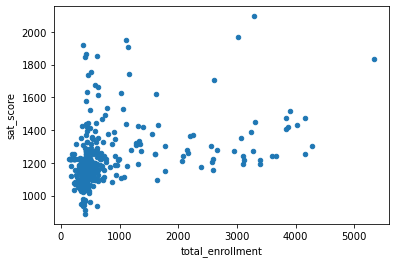

In [35]:
import matplotlib.pyplot as plt
combined.plot.scatter(x="total_enrollment", y="sat_score") # Specifying a certain plot type
plt.show()

It does not look like there is a strong correlation between `sat_score` and `total_enrollment`. However, there is an interesting cluster where both `sat_score` and `total_enrollment` are low. This might be what is making the r value so high. It might be worth extracting the names of the schools in this cluster so that we can investigate them more. 

In [36]:
low_enrollment = combined[combined['total_enrollment'] < 1000] # Filtering the dataframe to keep only relevant rows 
low_enrollment = low_enrollment[low_enrollment['sat_score'] < 1000] # Displaying all of the items in the School Name column of low_enrollment 
print(low_enrollment['School Name'])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


### Plotting Language Learning Percentage

It is believed that most of the high schools with low total enrollment and low SAt scores have high percentages of English language learners. This shows that it is actually `ell_percent` that is strongly correlated to `sat_score`, not `total_enrollment`. Let's plot out these two values t explore this relationship further.

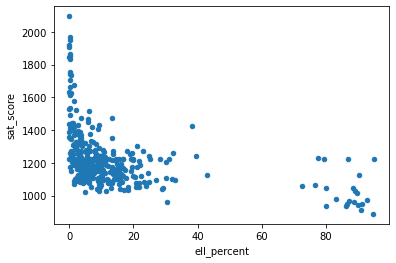

In [37]:
import matplotlib.pyplot as plt
combined.plot.scatter(x="ell_percent", y="sat_score")
plt.show()

### Calculating District-Level Statistics

Looking at the school-by-school variation makes it harder to analyse our data. One way to make this granular statistic easier to read is to aggregate them. We will now aggregate the data by district. In this way, we will be able to understand how `ell_percent` varies district-by-district. We will use the `groupby()` method as we did with `DBN` earlier on in our project. The only difference is that here we would find the mean of each column for each unique value in `school_dist`. 

In [38]:
import numpy

districts = combined.groupby('school_dist').agg(numpy.mean) # Grouping 'combined' by 'school_dist' and calculating the average of each group
districts.reset_index(inplace=True)
print(districts.head())

  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   
1          02                       426.619092           444.186256   
2          03                       428.529851           437.997512   
3          04                       402.142857           416.285714   
4          05                       427.159915           438.236674   

   SAT Writing Avg. Score    sat_score  AP Test Takers   Total Exams Taken  \
0              439.333333  1354.500000       116.681090         173.019231   
1              424.832836  1295.638184       128.908454         201.516827   
2              426.915672  1293.443035       156.183494         244.522436   
3              405.714286  1224.142857       129.016484         183.879121   
4              419.666098  1285.062687        85.722527         115.725275   

   Number of Exams with scores 3 4 or 5  Total Cohort  \
0                            135.800000     93.